In [1]:
import ROOT as rt
import uproot
# from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
import json

import gpustat
gpustat.print_gpustat()
os.environ['CUDA_VISIBLE_DEVICES']='3'

Welcome to JupyROOT 6.22/02
gpu-ibanks-3.hep.caltech.edu  Tue Dec  7 11:29:36 2021  470.57.02
[0] NVIDIA GeForce GTX 1080 | 23'C,   0 % |     4 /  8119 MB |
[1] NVIDIA GeForce GTX 1080 | 46'C,   0 % |  7233 /  8119 MB | 3054(7229M)
[2] NVIDIA GeForce GTX 1080 | 49'C,   0 % |  7243 /  8119 MB | 3054(7239M)
[3] NVIDIA GeForce GTX 1080 | 36'C,   0 % |  7219 /  8119 MB | 3054(7215M)
[4] NVIDIA GeForce GTX 1080 | 45'C,   0 % |  7219 /  8119 MB | 3054(7215M)
[5] NVIDIA GeForce GTX 1080 | 26'C,   0 % |   727 /  8119 MB | 3012(723M)
[6] NVIDIA GeForce GTX 1080 | 45'C,   0 % |  6669 /  8119 MB | 3054(6665M)
[7] NVIDIA GeForce GTX 1080 | 28'C,   0 % |     4 /  8119 MB |


In [2]:
def samp_to_df(samp_name):
    file_name = f'ML/DNN_Trees/combine_sequential_DNN/post_ms/{samp_name}_3.root'
    samp_file = uproot.open(file_name)
    samp_array = samp_file['tree'].arrays()
    samp_df = pd.DataFrame(samp_array)
    return samp_df

def data_to_df(samp_name):
    file_name = f'ML/DNN_Trees/combine_sequential_DNN/post_ms/{samp_name}_3.root'
    samp_file = uproot.open(file_name)
    samp_array = samp_file['tree'].arrays()
    samp_df = pd.DataFrame(samp_array)
    return samp_df

In [3]:
samples = ['sig', 'GluGluHtoGG', 'VBFHToGG', 'ttHToGG', 'VHToGG', 'nonres']
dfs = []
for samp in samples:
    dfs.append(samp_to_df(samp))

data_df = data_to_df('data_result')
data_sideband_df = data_to_df('data_sideband')

sig
Cat 1 Yield: 0.6205642096457991
Cat 1 #: 6330


Cat 2 Yield: 0.5090879968659371
Cat 2 #: 5231


Cat 3 Yield: 0.7004077138221758
Cat 3 #: 7782


Cat 4 Yield: 0.3302307296406521
Cat 4 #: 3676


GluGluHtoGG
Cat 1 Yield: 363.82462633873627
Cat 1 #: 20996


Cat 2 Yield: 80.08960278133654
Cat 2 #: 5164


Cat 3 Yield: 1.69411008424757
Cat 3 #: 92


Cat 4 Yield: 0.7709463317928655
Cat 4 #: 48


VBFHToGG
Cat 1 Yield: 26.512758842465278
Cat 1 #: 18093


Cat 2 Yield: 6.350353197799043
Cat 2 #: 5313


Cat 3 Yield: 0.12459005461309891
Cat 3 #: 68


Cat 4 Yield: 0.01692175609692781
Cat 4 #: 16


ttHToGG
Cat 1 Yield: 1.9722086989311827
Cat 1 #: 6411


Cat 2 Yield: 5.797541642654283
Cat 2 #: 18675


Cat 3 Yield: 0.06016598905899045
Cat 3 #: 195


Cat 4 Yield: 0.17661486486941386
Cat 4 #: 572


VHToGG
Cat 1 Yield: 58.67416236299478
Cat 1 #: 20735


Cat 2 Yield: 17.57435562979208
Cat 2 #: 9072


Cat 3 Yield: 1.0360014924282166
Cat 3 #: 319


Cat 4 Yield: 0.33224330435742594
Cat 4 #: 165


nonres
Cat

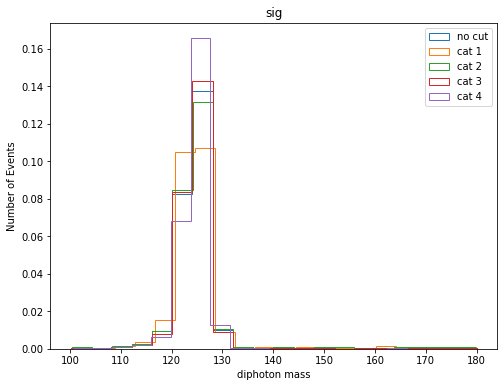

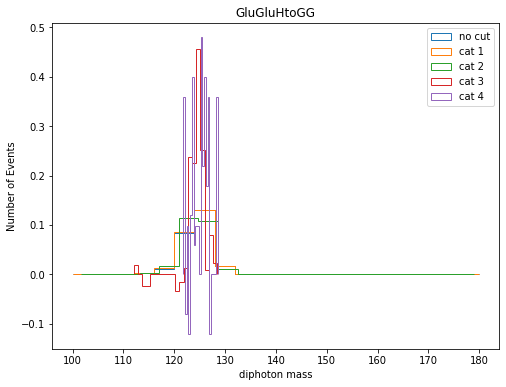

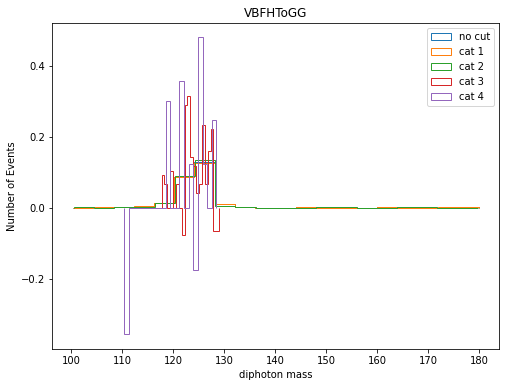

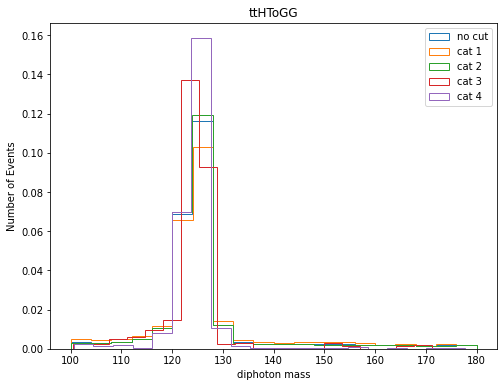

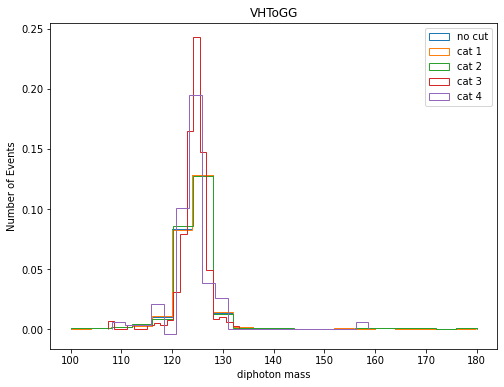

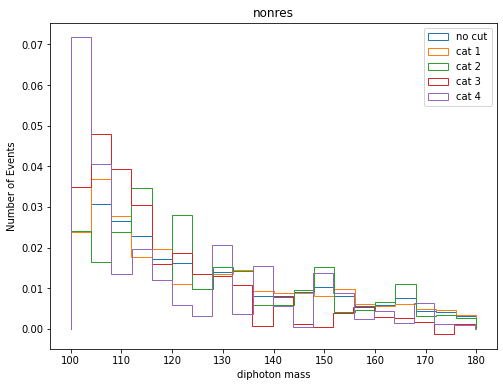

In [8]:
# DNN Cut and Bjet Cut

cat1_dfs = []
cat2_dfs = []
cat3_dfs = []
cat4_dfs = []
for df in dfs:
    d1_df = df[df[b'DNN_score'] <= 0.5]
    c1_df = d1_df[d1_df[b'nbjet'] == 2]
    c2_df = d1_df[d1_df[b'nbjet'] > 2]
    d2_df = df[df[b'DNN_score'] >= 0.5]
    c3_df = d2_df[d2_df[b'nbjet'] == 2]
    c4_df = d2_df[d2_df[b'nbjet'] > 2]
    cat1_dfs.append(c1_df)
    cat2_dfs.append(c2_df)
    cat3_dfs.append(c3_df)
    cat4_dfs.append(c4_df)
    
data_d1_df = data_df[data_df[b'DNN_score'] <= 0.5]
data_c1_df = data_d1_df[data_d1_df[b'nbjet'] == 2]
data_c2_df = data_d1_df[data_d1_df[b'nbjet'] > 2]
data_d2_df = data_df[data_df[b'DNN_score'] >= 0.5]
data_c3_df = data_d2_df[data_d2_df[b'nbjet'] == 2]
data_c4_df = data_d2_df[data_d2_df[b'nbjet'] > 2]

cat_dfs = [cat1_dfs, cat2_dfs, cat3_dfs, cat4_dfs]

c1_yields = []
c2_yields = []
c3_yields = []
c4_yields = []
c_yields = [c1_yields, c2_yields, c3_yields, c4_yields]

for i in range(len(samples)):
    print(samples[i])
    for j in range(len(cat_dfs)):
        weight = cat_dfs[j][i].loc[:,b'genweight_scale'].values
        c_yield = np.sum(weight)
        c_yields[j].append(c_yield)
        num_event = weight.shape[0]
        print(f'Cat {j+1} Yield: {c_yield}')
        print(f'Cat {j+1} #: {num_event}')
        print('\n')

print('yield by cat')    
for i in range(len(c_yields)):
    print(c_yields[i])
    
print('Data')
c1_yield = np.sum(data_c1_df.loc[:,b'genweight'].values)
c2_yield = np.sum(data_c2_df.loc[:, b'genweight'].values)
c3_yield = np.sum(data_c3_df.loc[:, b'genweight'].values)
c4_yield = np.sum(data_c4_df.loc[:, b'genweight'].values)
print(f'Cat 1 Yield: {c1_yield}')
print(f'Cat 2 Yield: {c2_yield}')
print(f'Cat 3 Yield: {c3_yield}')
print(f'Cat 4 Yield: {c4_yield}')
print('\n')

for i in range(len(samples)):
    plt.figure()
    plt.hist(dfs[i][b'diphoton_mass'], bins=20, histtype='step', label='no cut', weights = dfs[i][b'genweight_scale'], density = True) 
    plt.hist(cat1_dfs[i][b'diphoton_mass'], bins=20, histtype='step', label='cat 1', weights = cat1_dfs[i][b'genweight_scale'], density = True) 
    plt.hist(cat2_dfs[i][b'diphoton_mass'], bins=20, histtype='step', label='cat 2', weights = cat2_dfs[i][b'genweight_scale'], density = True)
    plt.hist(cat3_dfs[i][b'diphoton_mass'], bins=20, histtype='step', label='cat 3', weights = cat3_dfs[i][b'genweight_scale'], density = True) 
    plt.hist(cat4_dfs[i][b'diphoton_mass'], bins=20, histtype='step', label='cat 4', weights = cat4_dfs[i][b'genweight_scale'], density = True)
    plt.xlabel('diphoton mass')
    plt.ylabel("Number of Events")
    plt.title(f'{samples[i]}')
    plt.legend(loc='best')
    figure = plt.gcf()
    figure.set_size_inches(8, 6)
    #plt.savefig(fname = f'Plots/Data_MC_Plots/{year[y]}/recon(pho_80)/{plt_vars[x].decode("utf-8")}_{year[y]}_recon(pho_80).png', format='png', dpi = 100)
    plt.show()
    plt.close()

sig
Cat 1 Yield: 1.1296522065117363
Cat 2 Yield: 1.0306384434628277
Cat 1 #: 11561
Cat 2 #: 11458


GluGluHtoGG
Cat 1 Yield: 443.9142291200727
Cat 2 Yield: 2.4650564160404356
Cat 1 #: 26160
Cat 2 #: 140


VBFHToGG
Cat 1 Yield: 32.86311204026431
Cat 2 Yield: 0.14151181071002672
Cat 1 #: 23406
Cat 2 #: 84


ttHToGG
Cat 1 Yield: 7.769750341585468
Cat 2 Yield: 0.2367808539284043
Cat 1 #: 25086
Cat 2 #: 767


VHToGG
Cat 1 Yield: 76.24851799278686
Cat 2 Yield: 1.3682447967856426
Cat 1 #: 29807
Cat 2 #: 484


nonres
Cat 1 Yield: 330646.66182388907
Cat 2 Yield: 912.3419373554955
Cat 1 #: 504742
Cat 2 #: 1973


[1.1296522065117363, 443.9142291200727, 32.86311204026431, 7.769750341585468, 76.24851799278686, 330646.66182388907]
[1.0306384434628277, 2.4650564160404356, 0.14151181071002672, 0.2367808539284043, 1.3682447967856426, 912.3419373554955]
Data
Cat 1 Yield: 413118.0
Cat 2 Yield: 2222.0




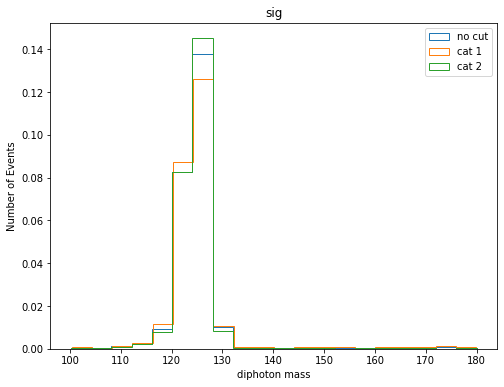

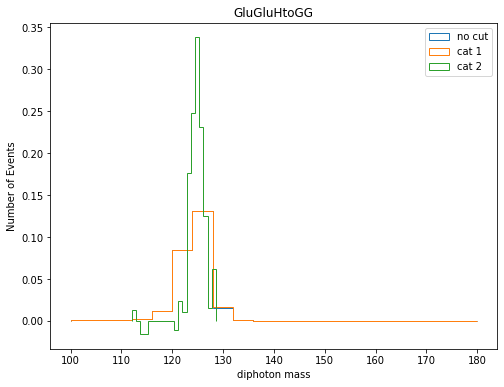

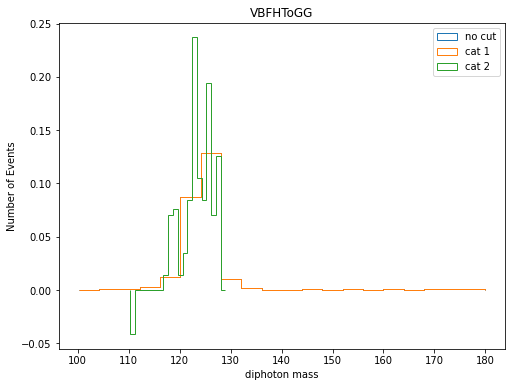

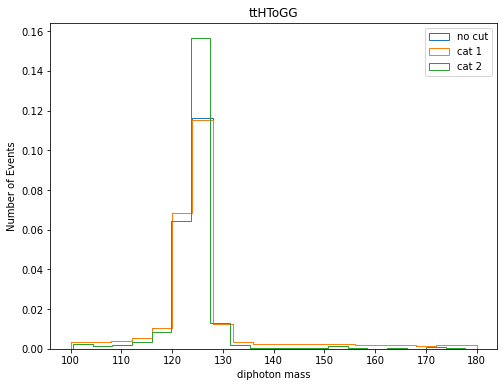

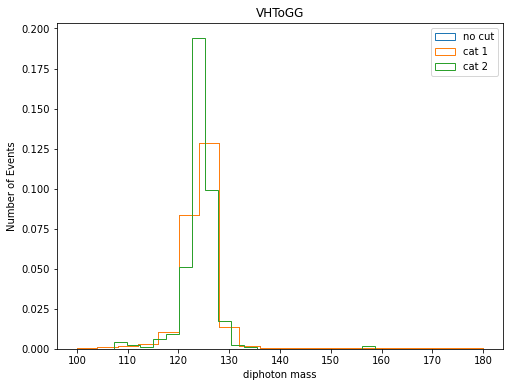

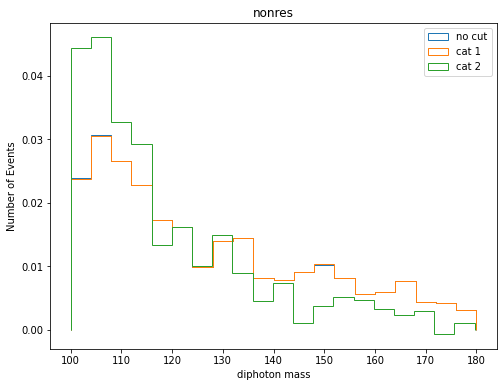

In [4]:
# DNN Cut

cat1_dfs = []
cat2_dfs = []
for df in dfs:
    c1_df = df[df[b'DNN_score'] <= 0.5]
    c2_df = df[df[b'DNN_score'] >= 0.5]
    cat1_dfs.append(c1_df)
    cat2_dfs.append(c2_df)
    
data_c1_df = data_df[data_df[b'DNN_score'] <= 0.5]
data_c2_df = data_df[data_df[b'DNN_score'] >= 0.5]

c1_yields = []
c2_yields = []

for i in range(len(samples)):
    print(samples[i])
    weight_1 = cat1_dfs[i].loc[:,b'genweight_scale'].values
    weight_2 = cat2_dfs[i].loc[:, b'genweight_scale'].values
    c1_yield = np.sum(weight_1)
    c2_yield = np.sum(weight_2)
    c1_yields.append(c1_yield)
    c2_yields.append(c2_yield)
    num_event_c1 = weight_1.shape[0]
    num_event_c2 = weight_2.shape[0]
    print(f'Cat 1 Yield: {c1_yield}')
    print(f'Cat 2 Yield: {c2_yield}')
    print(f'Cat 1 #: {num_event_c1}')
    print(f'Cat 2 #: {num_event_c2}')
    print('\n')
    
print(c1_yields)
print(c2_yields)
    
print('Data')
c1_yield = np.sum(data_c1_df.loc[:,b'genweight'].values)
c2_yield = np.sum(data_c2_df.loc[:, b'genweight'].values)
print(f'Cat 1 Yield: {c1_yield}')
print(f'Cat 2 Yield: {c2_yield}')
print('\n')

for i in range(len(samples)):
    plt.figure()
    plt.hist(dfs[i][b'diphoton_mass'], bins=20, histtype='step', label='no cut', weights = dfs[i][b'genweight_scale'], density = True) 
    plt.hist(cat1_dfs[i][b'diphoton_mass'], bins=20, histtype='step', label='cat 1', weights = cat1_dfs[i][b'genweight_scale'], density = True) 
    plt.hist(cat2_dfs[i][b'diphoton_mass'], bins=20, histtype='step', label='cat 2', weights = cat2_dfs[i][b'genweight_scale'], density = True)
    #plt.hist(cat3_dfs[i][b'diphoton_mass'], bins=20, histtype='step', label='cat 3', weights = cat3_dfs[i][b'genweight_scale'], density = True)
    plt.xlabel('diphoton mass')
    plt.ylabel("Number of Events")
    plt.title(f'{samples[i]}')
    plt.legend(loc='best')
    figure = plt.gcf()
    figure.set_size_inches(8, 6)
    #plt.savefig(fname = f'Plots/Data_MC_Plots/{year[y]}/recon(pho_80)/{plt_vars[x].decode("utf-8")}_{year[y]}_recon(pho_80).png', format='png', dpi = 100)
    plt.show()
    plt.close()

sig
Cat 1 Yield: 1.1296522065117363
Cat 2 Yield: 0.31127866026423284
Cat 3 Yield: 0.719359783198595
Cat 1 #: 11561
Cat 2 #: 3383
Cat 3 #: 8075


GluGluHtoGG
Cat 1 Yield: 443.9142291200727
Cat 2 Yield: 1.2448880295909879
Cat 3 Yield: 1.2201683864494477
Cat 1 #: 26160
Cat 2 #: 82
Cat 3 #: 58


VBFHToGG
Cat 1 Yield: 32.86311204026431
Cat 2 Yield: 0.10361052280805017
Cat 3 Yield: 0.037901287901976555
Cat 1 #: 23406
Cat 2 #: 57
Cat 3 #: 27


ttHToGG
Cat 1 Yield: 7.769750341585468
Cat 2 Yield: 0.14051734862810267
Cat 3 Yield: 0.09626350530030164
Cat 1 #: 25086
Cat 2 #: 456
Cat 3 #: 311


VHToGG
Cat 1 Yield: 76.24851799278686
Cat 2 Yield: 0.6627655883467121
Cat 3 Yield: 0.7054792084389305
Cat 1 #: 29807
Cat 2 #: 243
Cat 3 #: 241


nonres
Cat 1 Yield: 330646.66182388907
Cat 2 Yield: 594.0186604796266
Cat 3 Yield: 318.3232768758688
Cat 1 #: 504742
Cat 2 #: 1302
Cat 3 #: 671


[1.1296522065117363, 443.9142291200727, 32.86311204026431, 7.769750341585468, 76.24851799278686, 330646.66182388907]
[0.

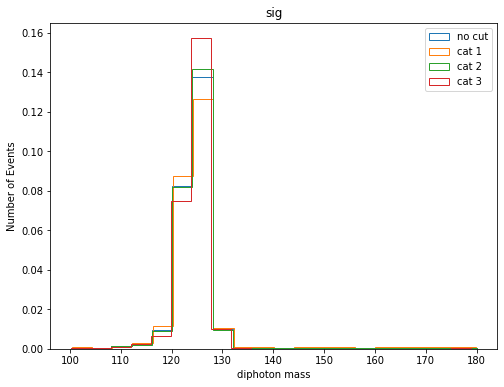

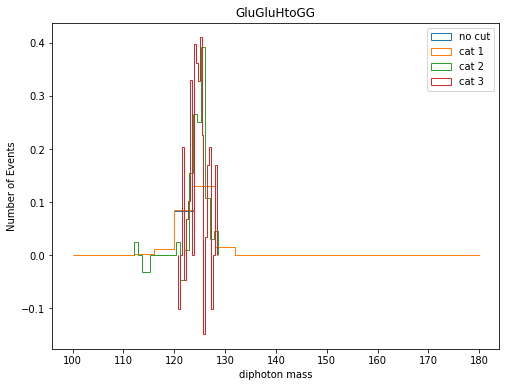

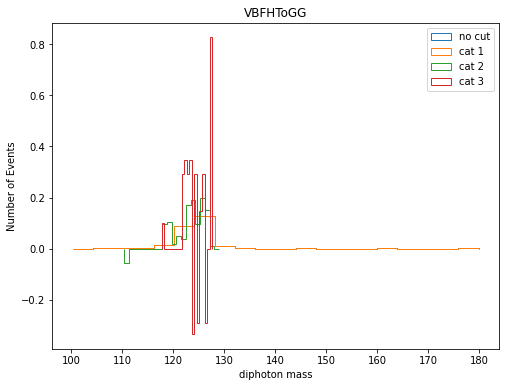

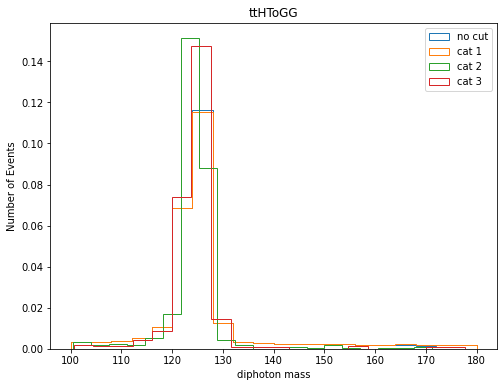

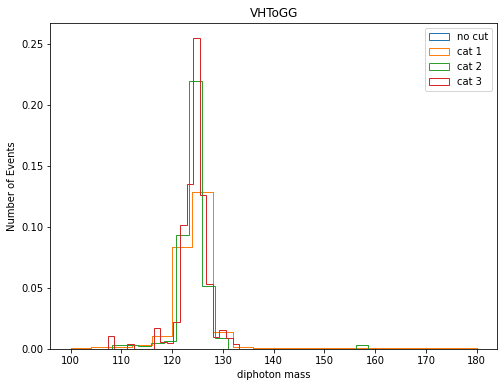

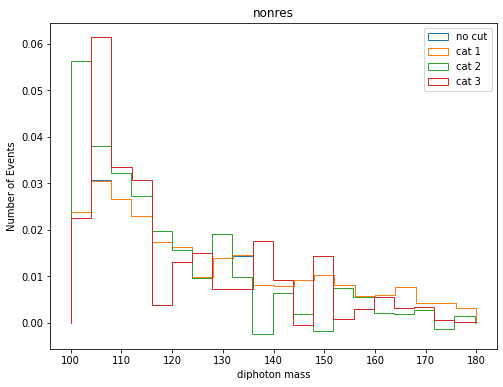

In [4]:
# DNN Cut

cat1_dfs = []
cat2_dfs = []
cat3_dfs = []
for df in dfs:
    c1_df = df[df[b'DNN_score'] <= 0.5]
    c2_df_1 = df[df[b'DNN_score'] >= 0.5]
    c2_df = c2_df_1[c2_df_1[b'DNN_score'] <= 0.7]
    c3_df = df[df[b'DNN_score'] >= 0.7]
    cat1_dfs.append(c1_df)
    cat2_dfs.append(c2_df)
    cat3_dfs.append(c3_df)
    
data_c1_df = data_df[data_df[b'DNN_score'] <= 0.5]
data_c2_df_1 = data_df[data_df[b'DNN_score'] >= 0.5]
data_c2_df = data_c2_df_1[data_c2_df_1[b'DNN_score'] <= 0.7]
data_c3_df = data_df[data_df[b'DNN_score'] >= 0.7]

c1_yields = []
c2_yields = []
c3_yields = []

for i in range(len(samples)):
    print(samples[i])
    weight_1 = cat1_dfs[i].loc[:,b'genweight_scale'].values
    weight_2 = cat2_dfs[i].loc[:, b'genweight_scale'].values
    weight_3 = cat3_dfs[i].loc[:, b'genweight_scale'].values
    c1_yield = np.sum(weight_1)
    c2_yield = np.sum(weight_2)
    c3_yield = np.sum(weight_3)
    c1_yields.append(c1_yield)
    c2_yields.append(c2_yield)
    c3_yields.append(c3_yield)
    num_event_c1 = weight_1.shape[0]
    num_event_c2 = weight_2.shape[0]
    num_event_c3 = weight_3.shape[0]
    print(f'Cat 1 Yield: {c1_yield}')
    print(f'Cat 2 Yield: {c2_yield}')
    print(f'Cat 3 Yield: {c3_yield}')
    print(f'Cat 1 #: {num_event_c1}')
    print(f'Cat 2 #: {num_event_c2}')
    print(f'Cat 3 #: {num_event_c3}')
    print('\n')
    
print(c1_yields)
print(c2_yields)
print(c3_yields)
    
print('Data')
c1_yield = np.sum(data_c1_df.loc[:,b'genweight'].values)
c2_yield = np.sum(data_c2_df.loc[:, b'genweight'].values)
c3_yield = np.sum(data_c3_df.loc[:, b'genweight'].values)
print(f'Cat 1 Yield: {c1_yield}')
print(f'Cat 2 Yield: {c2_yield}')
print(f'Cat 3 Yield: {c3_yield}')
print('\n')

for i in range(len(samples)):
    plt.figure()
    plt.hist(dfs[i][b'diphoton_mass'], bins=20, histtype='step', label='no cut', weights = dfs[i][b'genweight_scale'], density = True) 
    plt.hist(cat1_dfs[i][b'diphoton_mass'], bins=20, histtype='step', label='cat 1', weights = cat1_dfs[i][b'genweight_scale'], density = True) 
    plt.hist(cat2_dfs[i][b'diphoton_mass'], bins=20, histtype='step', label='cat 2', weights = cat2_dfs[i][b'genweight_scale'], density = True)
    plt.hist(cat3_dfs[i][b'diphoton_mass'], bins=20, histtype='step', label='cat 3', weights = cat3_dfs[i][b'genweight_scale'], density = True)
    plt.xlabel('diphoton mass')
    plt.ylabel("Number of Events")
    plt.title(f'{samples[i]}')
    plt.legend(loc='best')
    figure = plt.gcf()
    figure.set_size_inches(8, 6)
    #plt.savefig(fname = f'Plots/Data_MC_Plots/{year[y]}/recon(pho_80)/{plt_vars[x].decode("utf-8")}_{year[y]}_recon(pho_80).png', format='png', dpi = 100)
    plt.show()
    plt.close()

In [9]:
# Mass-Sculpting Cut

cat1_dfs = []
cat2_dfs = []
for df in dfs:
    c1_df = df[df[b'mass_sculpt_cut_sm'] == 1]
    c2_df = df[df[b'mass_sculpt_cut_sm'] == 0]
    cat1_dfs.append(c1_df)
    cat2_dfs.append(c2_df)
    
data_df_cat1 = data_df[data_df[b'mass_sculpt_cut_sm']==1]
data_df_cat2 = data_df[data_df[b'mass_sculpt_cut_sm']==0]

for i in range(len(samples)):
    print(samples[i])
    weight_1 = cat1_dfs[i].loc[:,b'genweight_scale'].values
    weight_2 = cat2_dfs[i].loc[:, b'genweight_scale'].values
    c1_yield = np.sum(weight_1)
    c2_yield = np.sum(weight_2)
    num_event_c1 = weight_1.shape[0]
    num_event_c2 = weight_2.shape[0]
    print(f'Cat 1 Yield: {c1_yield}')
    print(f'Cat 2 Yield: {c2_yield}')
    print(f'Cat 1 #: {num_event_c1}')
    print(f'Cat 2 #: {num_event_c2}')
    print('\n')
    
print('Data')
c1_yield = np.sum(data_df_cat1.loc[:,b'genweight'].values)
c2_yield = np.sum(data_df_cat2.loc[:, b'genweight'].values)
print(f'Cat 1 Yield: {c1_yield}')
print(f'Cat 2 Yield: {c2_yield}')
print('\n')

for i in range(len(samples)):
    plt.figure()
    plt.hist(cat1_dfs[i][b'diphoton_mass'], bins=20, histtype='step', label='cat 1', weights = cat1_dfs[i][b'genweight_scale'], density = True) 
    plt.hist(cat2_dfs[i][b'diphoton_mass'], bins=20, histtype='step', label='cat 2', weights = cat2_dfs[i][b'genweight_scale'], density = True)
    plt.xlabel('diphoton mass')
    plt.ylabel("Number of Events")
    plt.title(f'{samples[i]}')
    plt.legend(loc='best')
    figure = plt.gcf()
    figure.set_size_inches(8, 6)
    #plt.savefig(fname = f'Plots/Data_MC_Plots/{year[y]}/recon(pho_80)/{plt_vars[x].decode("utf-8")}_{year[y]}_recon(pho_80).png', format='png', dpi = 100)
    plt.show()
    plt.close()

sig
Cat 1 Yield: 1.7068664197030308
Cat 2 Yield: 0.4534242302715334
Cat 1 #: 18509
Cat 2 #: 4510


VBFHToGG
Cat 1 Yield: 1.0959048521002912
Cat 2 Yield: 31.908718998874054
Cat 1 #: 786
Cat 2 #: 22704


VHToGG
Cat 1 Yield: 5.21994282552886
Cat 2 Yield: 72.39681996404366
Cat 1 #: 1908
Cat 2 #: 28383


ttHToGG
Cat 1 Yield: 1.1280430728032806
Cat 2 Yield: 6.878488122710591
Cat 1 #: 3638
Cat 2 #: 22215


GluGluHtoGG
Cat 1 Yield: 12.939088373359791
Cat 2 Yield: 433.44019716275335
Cat 1 #: 893
Cat 2 #: 25407


nonres
Cat 1 Yield: 10543.927368493842
Cat 2 Yield: 321015.0763927506
Cat 1 #: 20799
Cat 2 #: 485916


Data
Cat 1 Yield: 21921.0
Cat 2 Yield: 393419.0




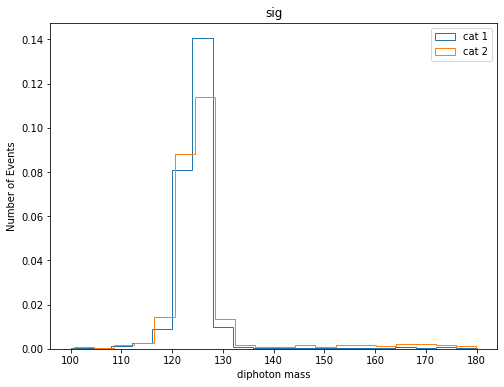

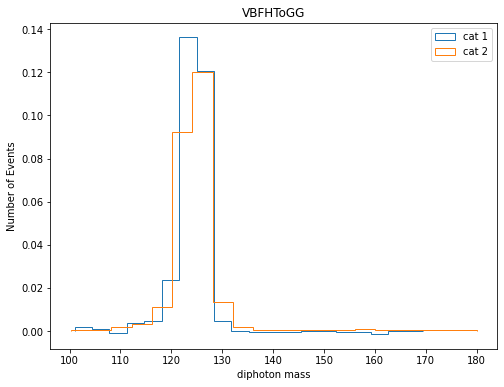

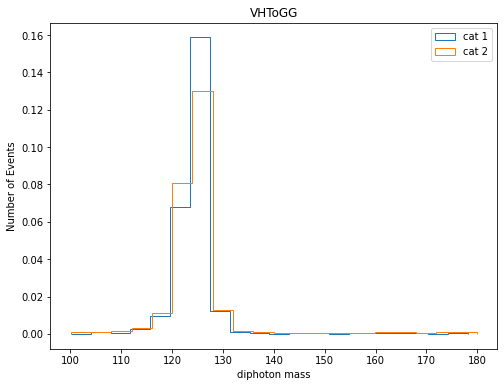

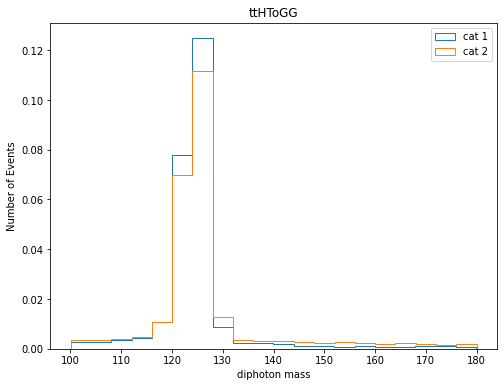

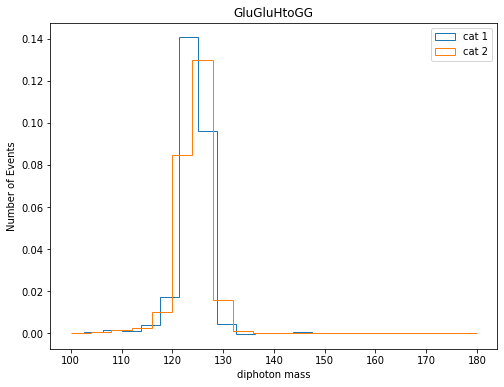

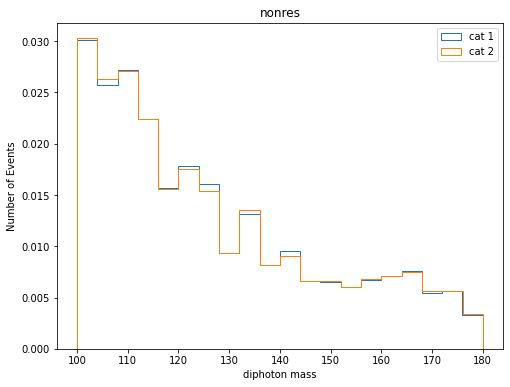

In [7]:
for i in range(len(samples)):
    plt.figure()
    plt.hist(cat1_dfs[i][b'diphoton_mass'], bins=20, histtype='step', label='cat 1', weights = cat1_dfs[i][b'genweight_scale'], density = True) 
    plt.hist(cat2_dfs[i][b'diphoton_mass'], bins=20, histtype='step', label='cat 2', weights = cat2_dfs[i][b'genweight_scale'], density = True)
    plt.xlabel('diphoton mass')
    plt.ylabel("Number of Events")
    plt.title(f'{samples[i]}')
    plt.legend(loc='best')
    figure = plt.gcf()
    figure.set_size_inches(8, 6)
    #plt.savefig(fname = f'Plots/Data_MC_Plots/{year[y]}/recon(pho_80)/{plt_vars[x].decode("utf-8")}_{year[y]}_recon(pho_80).png', format='png', dpi = 100)
    plt.show()
    plt.close()

combine -M AsymptoticLimits -m 125 -n v1 /storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/script/datacards/HHbbgg_datacard.txt --saveWorkspace --saveToys --run blind


combine -M AsymptoticLimits -m 125 -n dnncut /storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/script/datacards/HHbbgg_datacard.txt --saveWorkspace --saveToys --run blind

combine -M AsymptoticLimits -m 125 -n dnncut_novbf /storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/script/datacards/HHbbgg_datacard.txt --saveWorkspace --saveToys --run blind

combine -M AsymptoticLimits -m 125 -n dnn_nbjet_cut_novbf /storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/script/datacards/HHbbgg_datacard.txt --saveWorkspace --saveToys --run blind